# Examining irrigated area in the Nile Valley

## Import modules

In [1]:
%matplotlib inline
import datacube.utils.rio
import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datacube.helpers import write_geotiff
from skimage.segmentation import quickshift
import sys
from skimage import filters
from skimage import exposure

sys.path.append('../../examples/Scripts')
import deafrica_plotting
import deafrica_datahandling

import warnings
warnings.filterwarnings("ignore")

## Connect to the datacube

In [2]:
dc = datacube.Datacube(app='test_collections')

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)


## User inputs

In [3]:
lat =  24.50 #senegal 16.4558  
lon =  33.0 # -15.733
buff = 0.2
time = ('2013-06', '2019-02')
res = (-30, 30)

### View the selected location

In [ ]:
# deafrica_plotting.display_map(x=(lon-buff, lon+buff+0.275), y=(lat+buff, lat-buff))

## Load data and cloud mask

In [4]:
# Create a query object
queryC2 = {
    'x': (lon-buff, lon+buff+0.275),
    'y': (lat+buff, lat-buff),
    'time': (time),
    'resolution': res,
    'group_by': 'solar_day'
}

In [5]:
# find most common crs to allow
# native loading with correct crs
crs = deafrica_datahandling.mostcommon_crs(dc=dc,
                                          product='usgs_ls8c_level2_2',
                                          query=queryC2)

In [6]:
#load data
col2 = deafrica_datahandling.load_masked_usgs(dc=dc,
                                            products=['usgs_ls8c_level2_2'],
                                            output_crs=crs,
                                            measurements=['red', 'green', 'blue'], #'surface_temperature'
                                            dask_chunks = {'x':500, 'y':500},
                                            lazy_load=True,
                                            align=(15, 15),
                                            **queryC2)


Loading usgs_ls8c_level2_2 data
    Using pixel quality parameters for USGS Collection 2
    Applying pixel quality mask
Combining and sorting data
    Returning 257 observations as a dask array


## Calculate irrigated area using seasonal maximum ndvi


In [ ]:
#calculate ndvi
ndvi = ((col2.nir - col2.red)/(col2.nir + col2.red))

#calculate seasonal max ndvi
ndvi_smax = ndvi.resample(time='QS-JUN').max('time')
ndvi_smax = ndvi_smax.fillna(0)

In [ ]:
ndvi_smax = ndvi_smax.compute()

In [ ]:
# thresholds = [0.2, 0.25, 0.30, 0.35, 0.40]
thresholds = [0.30]

#create padas dataframe for adding results too
data_dict = {'Season': ndvi_smax.time.values}
irr_area = pd.DataFrame(data=data_dict).set_index('Season')

# Loop through thresholds and seasons and calculate area above threshold
for thres in thresholds:
    print("working on threshold "+ str(thres))
    
    areas = []
    for i in range(len(ndvi_smax.time)):
        
        # Convert our mean NDVI xarray into a numpy array
        input_array = ndvi_smax.isel(time=i).values
        
        irr = input_array >= thres
        area = np.count_nonzero(irr) * (30*30) / 10000
        areas.append(area)
        
    name=str(thres)
    irr_area[name] = areas


### Plot irrigated time series

In [ ]:
styles=['bs--', 'ro-', 'y^-', 'go-', 'rs-']
irr_area.plot(figsize=(16,8), style = styles, legend=False)

## Animations

###  line plot animation of irrigation

In [ ]:
# irr_area.columns(['Season', ('Ha')])

In [ ]:
deafrica_plotting.animated_timeseriesline(
    ndvi_smax.fillna(0).rename("Seasonal Maximum NDVI").to_dataset(), #.rolling(time=4, center=True, min_periods=1).mean()
    irr_area,
    "egypt_seasonal_irrigation_cividis.gif",
    width_pixels=1000,
    interval=300,
    bands=["Seasonal Maximum NDVI"],
    onebandplot_cbar=False,
    show_date=False,
    title="Seasonal Irrigated Area (ha)",
    onebandplot_kwargs={"cmap": "cividis", "vmax":"0.55"},
    pandasplot_kwargs={"legend":False, "style": "bs--"},
)

### True colour animation

In [7]:
rgb = col2.resample(time='QS-JUN').mean('time').compute()


Generating 23 frame animation
    Exporting animation to rgb.gif


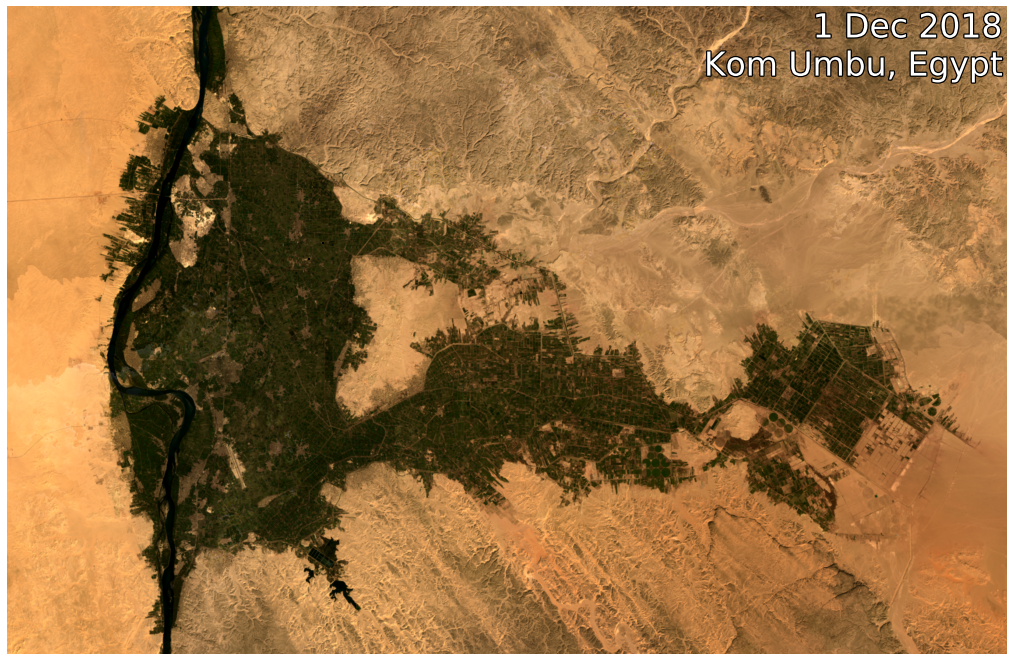

In [12]:
deafrica_plotting.animated_timeseries(rgb, 'rgb.gif',
                                      width_pixels=1000, interval=300,
                                      bands=['red', 'green', 'blue'],
                                      percentile_stretch=(0.01, 0.99),
                                      annotation_kwargs={'fontsize': 33},
                                      title='Kom Umbu, Egypt',
                                      show_date=True
                                      )


## Experimenting with LST

In [ ]:
#calculate mean seasonal surface temp 
ST_mean = col2.surface_temperature.resample(time='QS-JUN').mean('time')
ST_mean = ST_mean.fillna(0) #need to get rid of nans

#calculate seasonal max ndvi
ndvi = ((col2.nir - col2.red)/(col2.nir + col2.red))
ndvi_smax = ndvi.resample(time='QS-JUN').max('time')
ndvi_smax = ndvi_smax.fillna(0)

In [ ]:
# ndvi_smax = ndvi_smax.compute()
ST_mean = ST_mean.compute()

In [ ]:
areas_LST=[]
for i in range(len(ST_mean.time)):
    #use OTSU to dynamically find thresholds
    val_temp = filters.threshold_otsu(ST_mean.isel(time=i).values)
#     val_ndvi = filters.threshold_otsu(ndvi_smax.isel(time=i).values)
#     print(val_temp)
    
    #use thresholds to classify images
    crop = ndvi_smax.isel(time=i).values >= 0.3
    wet = ST_mean.isel(time=i).values <= val_temp
    irr = crop & wet
    
    #count area irrigated
    area = np.count_nonzero(irr) * (30*30) / 10000
    areas_LST.append(area)
    

In [ ]:
#create padas dataframe for adding results too
data_dict = {'Season': ndvi_smax.time.values, 'Irrigated Area (ha)': areas_LST}
irr_area_LST = pd.DataFrame(data=data_dict).set_index('Season')

In [ ]:
irr_area.plot(figsize=(10,5), style = 'bs-')

In [ ]:
print(np.count_nonzero(crop))
print(np.count_nonzero(wet))
print(np.count_nonzero(irr))

In [ ]:
# Export the array
# Plot to see result
# x = xr.open_rasterio('results_sica/2018-12-01_0.5.tif').squeeze()
# plt.figure(figsize=(20,20))
# plt.imshow(irr, cmap='gist_earth_r', vmin=0.0, vmax=0.6)
# plt.colorbar(shrink=0.5)



# name = str(ndvi_smax.time.values[i])[:10] + "_" + str(thres)
# dea_datahandling.array_to_geotiff('results_sica/201812_rgb.tif',
#                                   ndvi_smax.isel(time=22).values,
#                                   geo_transform=transform,
#                                   projection=projection,
#                                   nodata_val=np.nan)


# transform = col2.geobox.transform.to_gdal()
# projection = col2.geobox.crs.wkt

#         # Calculate the segments
#         segments = quickshift(input_array,
#                               kernel_size=1,
#                               convert2lab=False,
#                               max_dist=10,
#                               ratio=0.5)
        
#         # Calculate the zonal mean NDVI across the segments
#         segments_zonalMean = scipy.ndimage.mean(input=input_array,
#                                                     labels=segments,
#                                                     index=segments)
        
#         irr = segments_zonalMean >= thres

#calculate yearly mas ndvi
# ndvi_max = ndvi.groupby('time.year').max('time').rename('ndvi_max')

In [ ]:
    
#     print(val)
#     hist, bins_center = exposure.histogram(ST_mean.isel(time=i).values)

#     plt.figure(figsize=(10, 5))
#     plt.subplot(121)
#     plt.imshow(ST_mean.isel(time=i).values < val, cmap='gray', interpolation='nearest')
#     plt.subplot(122)
#     plt.plot(bins_center, hist, lw=2)
#     plt.axvline(val, color='k', ls='--')

#     plt.tight_layout()
#     plt.show()